## Principal Component Analysis


ans =

   2.1244e-13




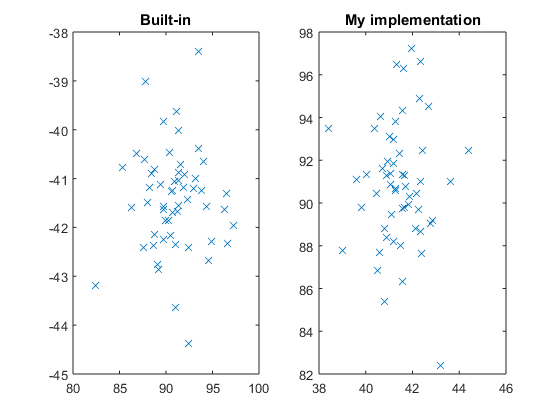

In [1]:
clear all
load RunTimeData.mat
[coeff,score,~,~,explained_data] = pca(data);
projdata = data*coeff(:,1:2);
subplot(121), plot(projdata(:,1),projdata(:,2),'x') , title('Built-in')
[eigvec, eigval] = eig(cov(data));
pca_data = (eigvec(:,end-1:end)'*data')';   % pca_data = data*eigvec(:,end-1:end)
subplot(122), plot(pca_data(:,1),pca_data(:,2),'x') , title('My implementation')
sum(sum(abs((bsxfun(@minus,data,mean(data,1)))-score*coeff')))        % should give 0

## PCA feature selection and AdaBoost

### prepare data

In [ ]:
clear all; clc; 
load('MEGdata.mat')  

idx1 = find(VideoClass==1);
idx2 = find(VideoClass==2);

data = double( MEGdata([idx1;idx2],:,:));
class = double (VideoClass([idx1;idx2]));


N = size(class,1);     % Number of samples
Ntest = 50;
Ntrain = N - Ntest;

idx = randperm(N);      
trndata = double( data(idx(1:Ntrain),:,:));
trnclass = double ( class(idx(1:Ntrain)));

NumOfClasses = length(unique(trnclass));


testdata = double( data(idx(Ntrain+1:end),:,:) );
testclass = double( class(idx(Ntrain+1:end)));

trn_feature = [mean(trndata,3) var(trndata,0,3)];
test_feature = [mean(testdata,3) var(testdata,0,3)];

### pca feature selection

In [ ]:
% [eigvec_trn, eigval_trn] = eig(cov(trn_feature));
% [eigvec_test, eigval_test] = eig(cov(test_feature));

[coeff_trn,~,~,~,explained_trn] = pca(trn_feature);
[coeff_test,~,~,~,explained_test] = pca(test_feature);
trn_feature_hat = trn_feature*coeff_trn(:,1:25);
test_feature_hat = test_feature*coeff_test(:,1:25);

### AdaBoost
- Adaboost algorithm using WLSQ (Weighted Least Squares) classifier as base classifier. The weighted least square fit is given by

$$
\beta = (X^TWX)^{-1} X^TWy
$$

where $W$ is diagonal matrix containing data importance weights, $X$ is a matrix containing data training samples and 1 on it's rows, and $y$ is a vector of values 1 and -1 indicating class label.

In [ ]:
L = 5;  % boosting round (Number of base learners)
w = 1/Ntrain * ones(1,Ntrain);  % initialize weights
W = diag(w);                    % diagonal weight matrix
beta = zeros(size(trn_feature_hat,2),L);
err = 0.1*ones(1,L);    % error rate for each base learners

% Training Phase
for j=1:L   % for all base learners

    % randomly draw X_j from X with probability w_j
    randIdx = randsrc(Ntrain,1,[1:Ntrain;w]);
    X = trn_feature_hat(randIdx,:);

    %true_y = -1*ones(1,Ntrain);     % true class labels
    true_trn_y = trnclass(randIdx)';
    true_trn_y(true_trn_y==2) = -1;     % Class 1 -> 1, Class2 -> -1
    beta(:,j) = ((X'*W*X)\X')*W*true_trn_y';
    predicted_y = sign(X*beta(:,j));
    err(j) = sum(w(true_trn_y~=predicted_y'));
    if err(j) <= 0 || err(j)>0.5
       break; 
    else
        % adjust weights for missclassfified patterns (to increase their importance)
        w(true_trn_y~=predicted_y') = w(true_trn_y~=predicted_y')*(1-err(j))/err(j);
        w = w./sum(w);  % normalize probabilities
        W = diag(w);
    end
end


% Testing Phase
predicted_ensemble_y = zeros(Ntest,L);
for j=1:L
    predicted_ensemble_y(:,j) = sign(test_feature_hat*beta(:,j));
end

### Aggregating

In [ ]:
predicted_test_y = zeros(Ntest,1);
for i=1:Ntest
    predicted_test_y(i,:) = sign(sum(log((1-err)./err).*predicted_ensemble_y(i,:)));
end

true_test_y =  testclass;
true_test_y(true_test_y==2) = -1;

TestPredAcc = mean(predicted_test_y==true_test_y)